In [1]:
import os
from math import ceil, floor
from typing import Dict, List, Optional, Union
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from statistics import stdev
from numpy import nanstd, isnan, nan
import random
from scipy import linalg
import torch
from anndata import AnnData, concat
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif
from CauFinder.dataloader import zscore_normalization, apply_activation
from CauFinder.benchmark import run_caufinder121
import chardet
from CauFinder.caufinder_main import CausalFinder, CauShapNet
from CauFinder.benchmark import cumulative_weight_sum_rate
from scipy.stats import mannwhitneyu, ttest_ind
from sklearn.decomposition import PCA
from CauFinder.utils import set_seed, plot_feature_boxplots, merge_basic_driver, merge_complex_driver
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from CauFinder.utils import load_luas_human_adata, human_all_adata, human_data_direction, calculate_w1_w2, find_index
from CauFinder.utils import result_add_direction, plot_control_scores, plot_control_scores_by_category
from CauFinder.utils import plot_3d_state_transition, plot_causal_feature_transitions
import umap

import scanpy as sc
import pickle as pkl
import collections as ct
import warnings

/sibcb1/chenluonanlab8/miaoyuanxiang/miniforge3/envs/GAE/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-06-20 17:59:22.080354: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-20 17:59:22.282406: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
BASE_DIR = '/sibcb1/chenluonanlab8/miaoyuanxiang/CauFinder-master'

In [4]:
case_dir = os.path.join(BASE_DIR, 'LUAS', 'human')
data_path = os.path.join(case_dir, 'data')
output_path = os.path.join(case_dir, 'output', 'new_model')
os.makedirs(output_path, exist_ok=True)

tf_path = os.path.join(BASE_DIR, 'resources', 'tf', 'hs_hgnc_tfs_lambert2018.txt')
network_path = os.path.join(BASE_DIR, 'resources', 'network', 'NicheNet_human.csv')
tf_list = pd.read_csv(tf_path, header=None, squeeze=True).tolist()
prior_network = pd.read_csv(network_path, index_col=None, header=0)
adata, adata_filter = load_luas_human_adata(data_dir=data_path, tf_list=tf_list)



/var/tmp/ipykernel_105616/3426956463.py:8: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  tf_list = pd.read_csv(tf_path, header=None, squeeze=True).tolist()


In [5]:
with open('/sibcb1/chenluonanlab8/miaoyuanxiang/CauFinder-master/LUAS/human/output/new_model/adata_filter.pkl', 'wb') as file:
    pkl.dump(adata_filter, file)
with open('/sibcb1/chenluonanlab8/miaoyuanxiang/CauFinder-master/LUAS/human/output/new_model/adata.pkl', 'wb') as file:
    pkl.dump(adata, file)

In [6]:
with open('/sibcb1/chenluonanlab8/miaoyuanxiang/CauFinder-master/LUAS/human/output/new_model/_seed60.pkl', 'rb') as file:
    model = pkl.load(file)

In [7]:
driver_info = pd.read_csv(f"/sibcb1/chenluonanlab8/miaoyuanxiang/CauFinder-master/LUAS/human/output/new_model/driver_summary_shap_total.csv",index_col=0)

In [8]:
drivers = driver_info.index.to_list()

In [9]:
adata_increase = model.guided_state_transition(
        adata=adata_filter,
        causal_features=drivers,lambda_reg=1e-6,lr=0.1,max_iter=300,
        target_state = 1
        #control_direction="increase",
        #grad_source="logit",
    )

Processing sample 0, Target direction: increase
Processing sample 1, Target direction: increase
Processing sample 2, Target direction: increase
Processing sample 3, Target direction: increase
Processing sample 4, Target direction: increase
Processing sample 5, Target direction: increase
Processing sample 6, Target direction: increase
Processing sample 7, Target direction: increase
Processing sample 8, Target direction: increase
Processing sample 9, Target direction: increase
Processing sample 10, Target direction: increase
Processing sample 11, Target direction: increase
Processing sample 12, Target direction: increase
Processing sample 13, Target direction: increase
Processing sample 14, Target direction: increase
Processing sample 15, Target direction: increase
Processing sample 16, Target direction: increase
Processing sample 17, Target direction: increase
Processing sample 18, Target direction: increase
Processing sample 19, Target direction: increase
Processing sample 20, Target d

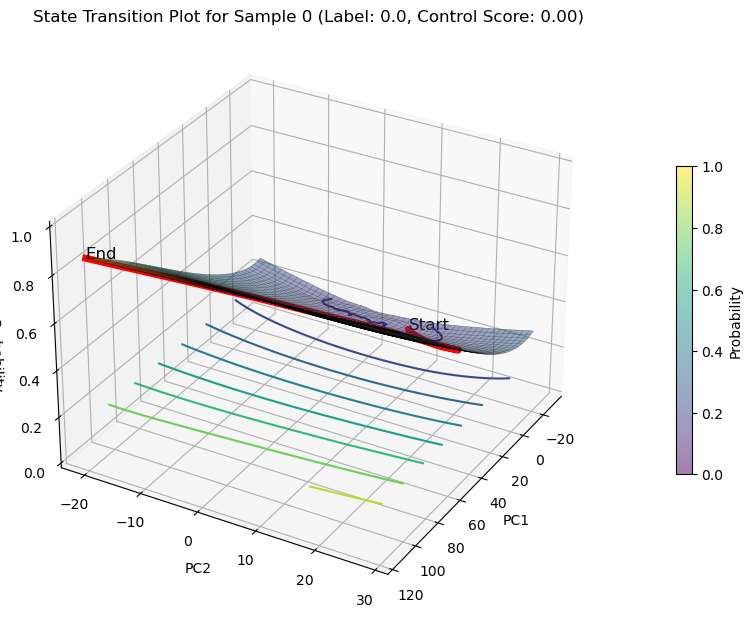

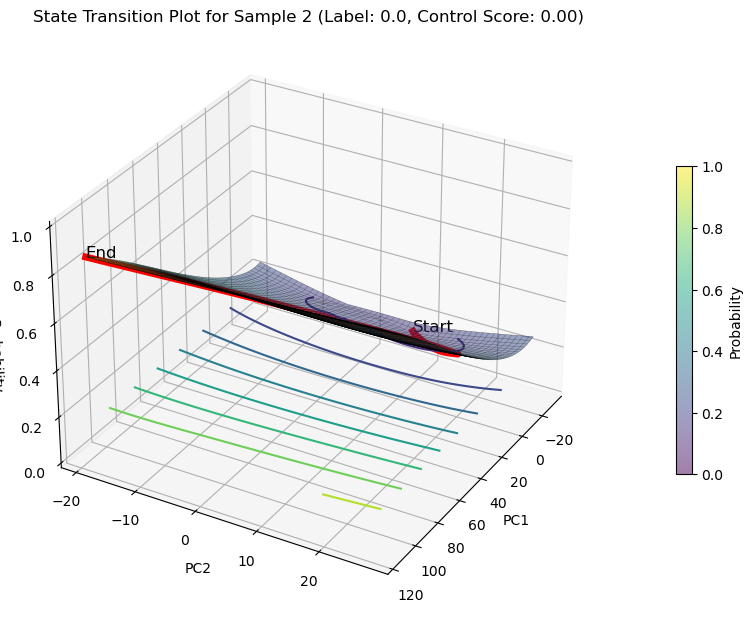

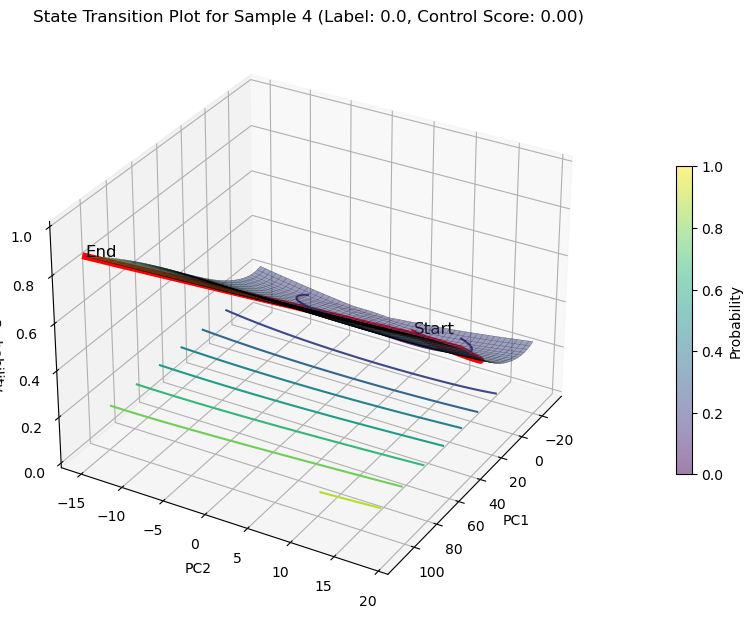

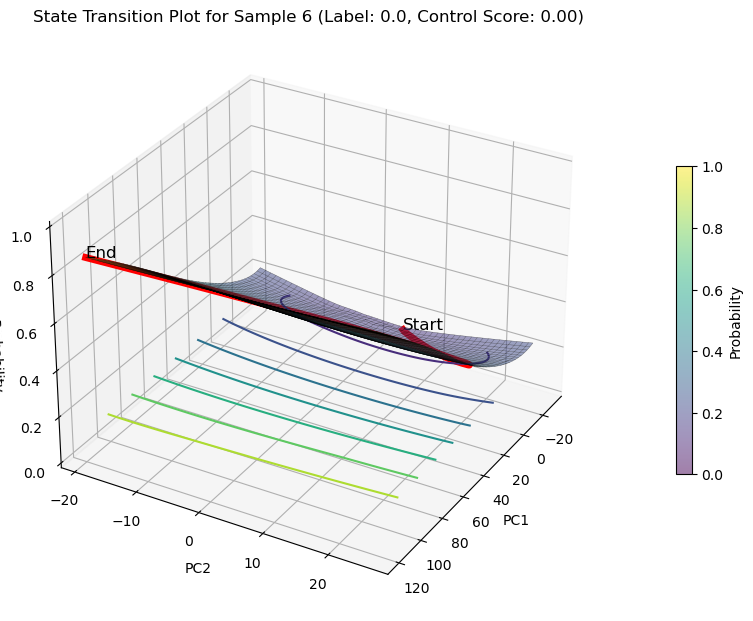

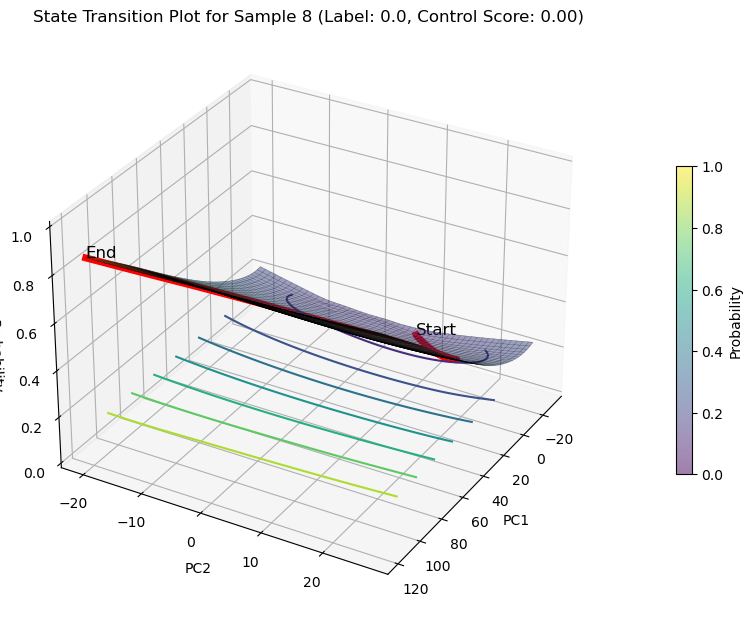

In [60]:
plot_3d_state_transition(adata_increase, sample_indices=[0,2,4,6,8], use_pca=True)

In [63]:
adata_decrease = model.guided_state_transition(
        adata=adata_filter,
        causal_features=drivers,lambda_reg=1e-6,lr=0.1,max_iter=300,
        target_state = 0
        #control_direction="increase",
        #grad_source="logit",
    )

Processing sample 0, Target direction: decrease
Processing sample 1, Target direction: decrease
Processing sample 2, Target direction: decrease
Processing sample 3, Target direction: decrease
Processing sample 4, Target direction: decrease
Processing sample 5, Target direction: decrease
Processing sample 6, Target direction: decrease
Processing sample 7, Target direction: decrease
Processing sample 8, Target direction: decrease
Processing sample 9, Target direction: decrease
Processing sample 10, Target direction: decrease
Processing sample 11, Target direction: decrease
Processing sample 12, Target direction: decrease
Processing sample 13, Target direction: decrease
Processing sample 14, Target direction: decrease
Processing sample 15, Target direction: decrease
Processing sample 16, Target direction: decrease
Processing sample 17, Target direction: decrease
Processing sample 18, Target direction: decrease
Processing sample 19, Target direction: decrease
Processing sample 20, Target d

In [11]:
with open('/sibcb1/chenluonanlab8/miaoyuanxiang/CauFinder-master/LUAS/human/output/new_model/adata_increase.pkl', 'wb') as file:
    pkl.dump(adata_increase, file)
with open('/sibcb1/chenluonanlab8/miaoyuanxiang/CauFinder-master/LUAS/human/output/new_model/adata_decrease.pkl', 'wb') as file:
    pkl.dump(adata_decrease, file)

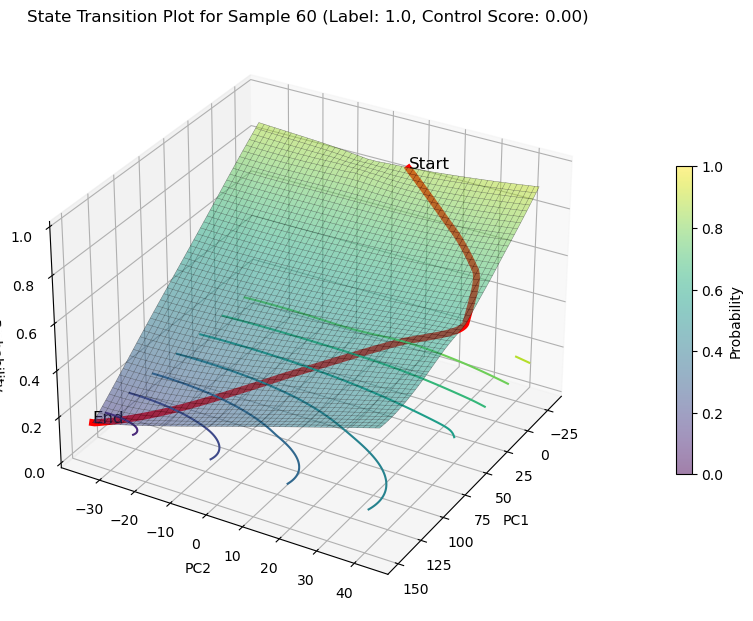

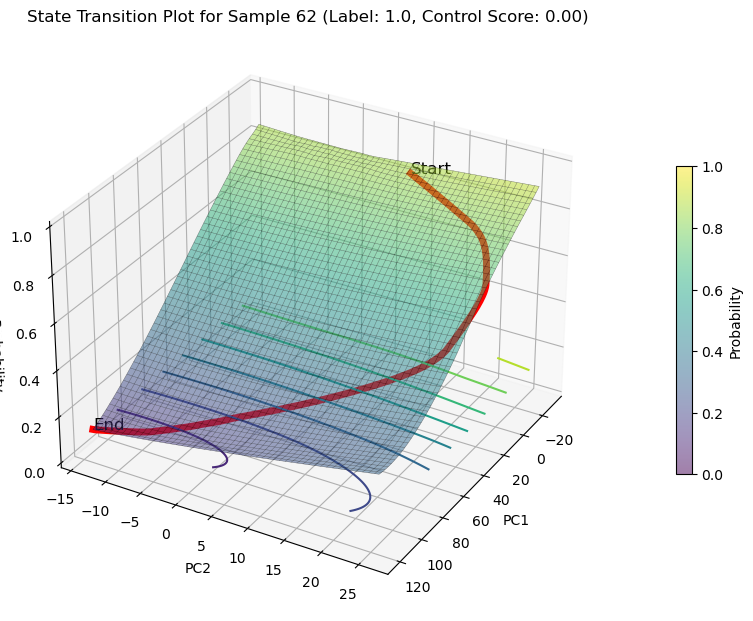

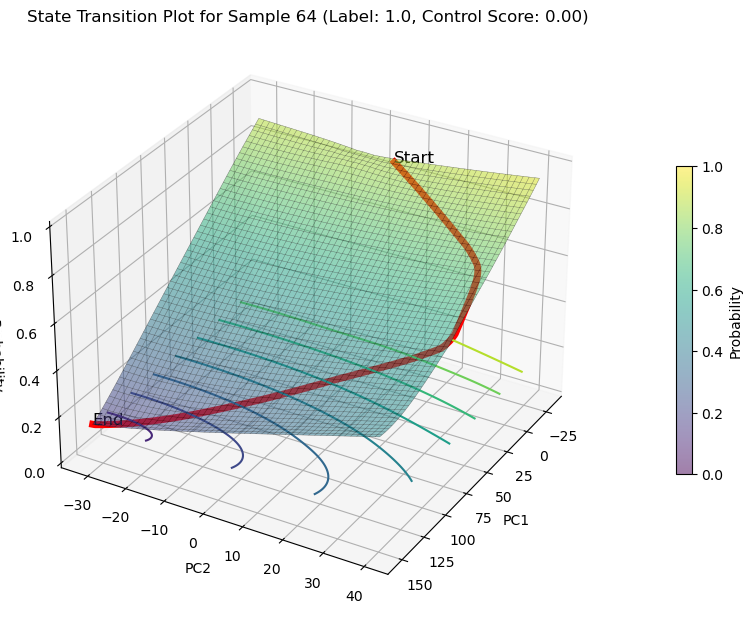

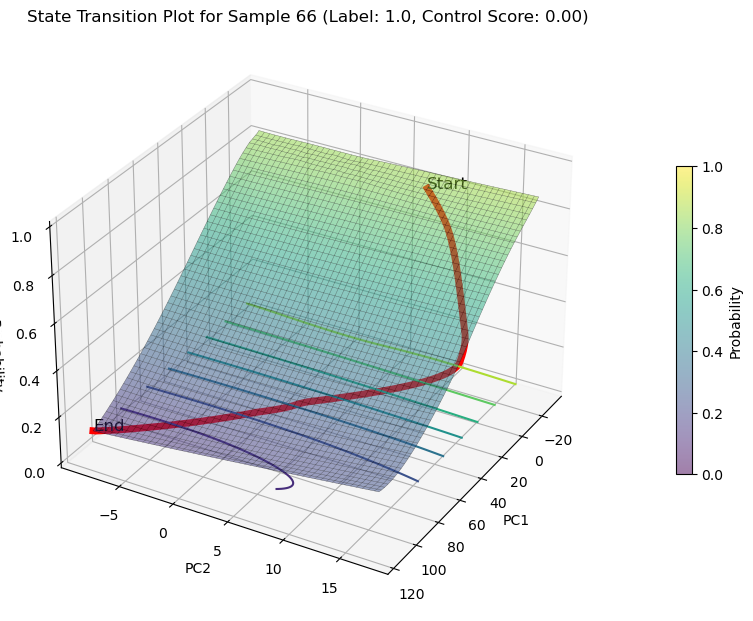

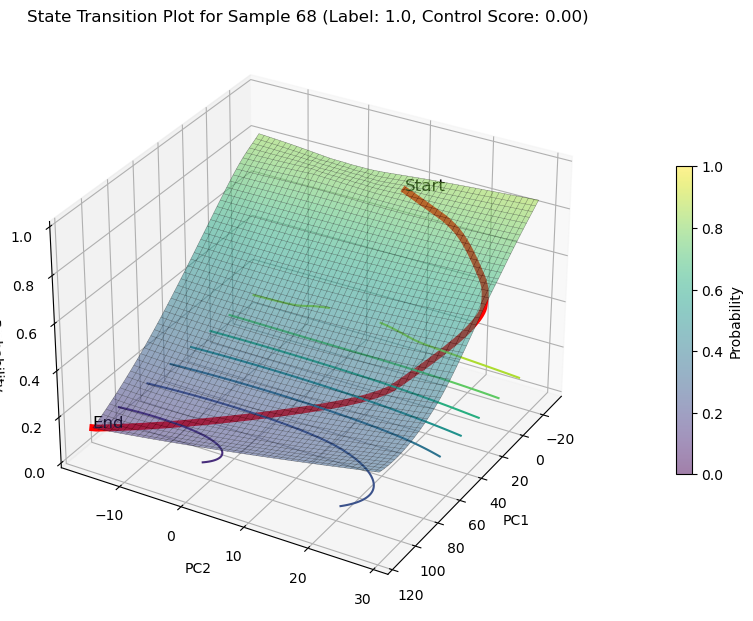

In [64]:
plot_3d_state_transition(adata_decrease, sample_indices=[60,62,64,66,68], use_pca=True)

## draw PCA

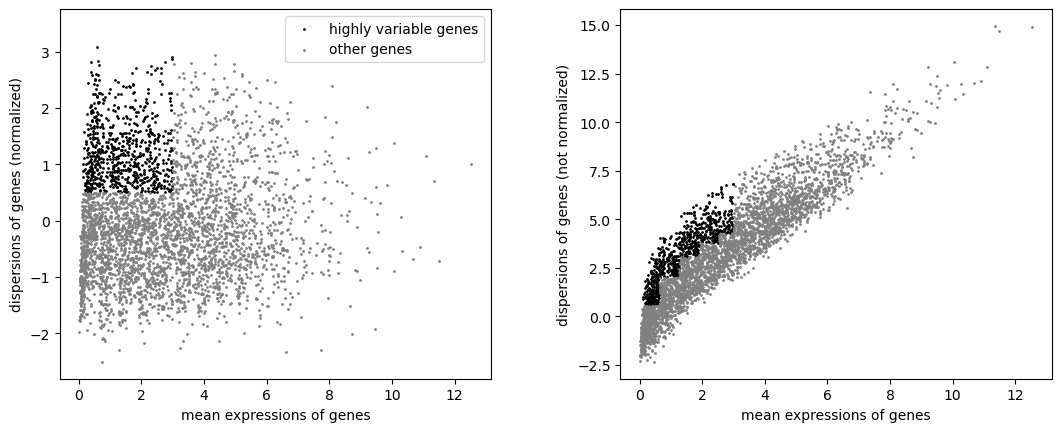

/sibcb1/chenluonanlab8/miaoyuanxiang/miniforge3/envs/GAE/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:229: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm['X_pca'] = X_pca


In [126]:
test_adata = adata_filter.copy()
sc.pp.highly_variable_genes(test_adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(test_adata)

test_adata.raw = test_adata
test_adata = test_adata[:, test_adata.var.highly_variable]
sc.tl.pca(test_adata, svd_solver="arpack",n_comps=30)

/sibcb1/chenluonanlab8/miaoyuanxiang/miniforge3/envs/GAE/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:364: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


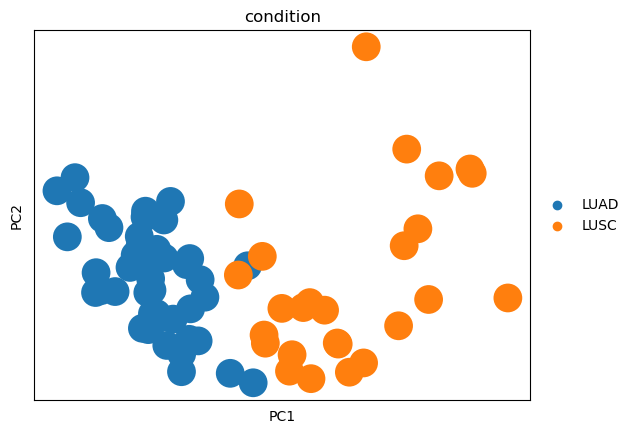

In [127]:
sc.pl.pca(test_adata,color='condition')

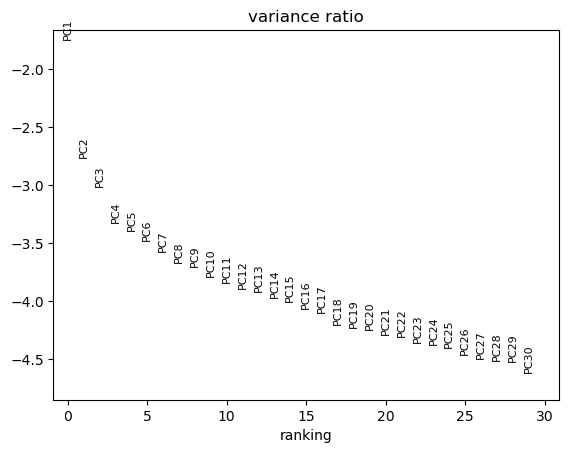

In [128]:
sc.pl.pca_variance_ratio(test_adata, log=True)

In [129]:
sc.pp.neighbors(test_adata, n_neighbors=4, n_pcs=10)

In [130]:
sc.tl.umap(test_adata)

/sibcb1/chenluonanlab8/miaoyuanxiang/miniforge3/envs/GAE/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:364: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


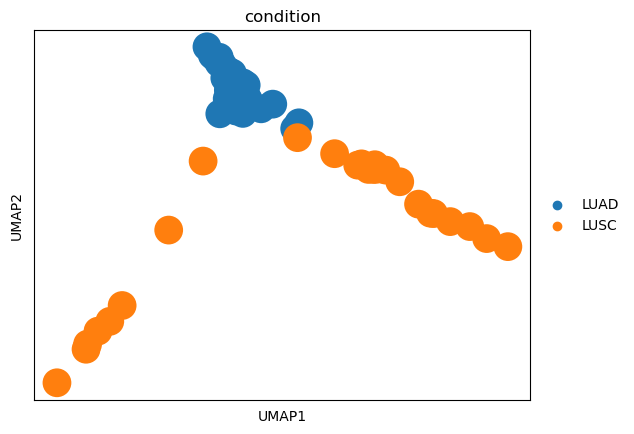

In [131]:
sc.pl.umap(test_adata,color='condition')

### color with increase score

In [133]:
df1 = test_adata.obs
df2 = adata_increase.uns['control_details']
df2['sample_idx'] = pd.Series([str(i) for i in df2['sample_idx']],dtype="category",name='sample_idx',index=df2.index.to_list())
df2.index = df1.index

test_adata.obs = pd.concat([df1,df2],axis=1)

/sibcb1/chenluonanlab8/miaoyuanxiang/miniforge3/envs/GAE/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:343: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/sibcb1/chenluonanlab8/miaoyuanxiang/miniforge3/envs/GAE/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:352: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(


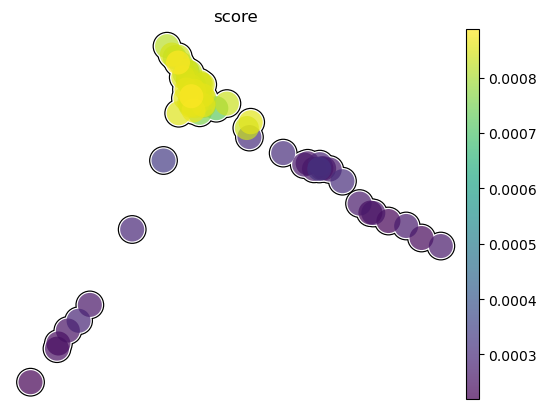

In [137]:
sc.pl.umap(test_adata,color='score',legend_loc="on data",size=1200,legend_fontsize=16,palette="Set2",
    frameon=False,add_outline=True,outline_width=(0.05,0.05))

/sibcb1/chenluonanlab8/miaoyuanxiang/miniforge3/envs/GAE/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:343: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/sibcb1/chenluonanlab8/miaoyuanxiang/miniforge3/envs/GAE/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:352: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/sibcb1/chenluonanlab8/miaoyuanxiang/miniforge3/envs/GAE/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:364: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


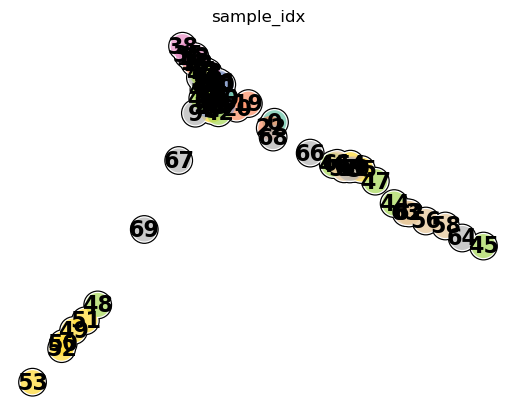

In [136]:
sc.pl.umap(test_adata,color='sample_idx',legend_loc="on data",size=1200,legend_fontsize=16,palette="Set2",
    frameon=False,add_outline=True,outline_width=(0.05,0.05))

/sibcb1/chenluonanlab8/miaoyuanxiang/miniforge3/envs/GAE/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:343: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/sibcb1/chenluonanlab8/miaoyuanxiang/miniforge3/envs/GAE/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:352: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/sibcb1/chenluonanlab8/miaoyuanxiang/miniforge3/envs/GAE/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:364: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


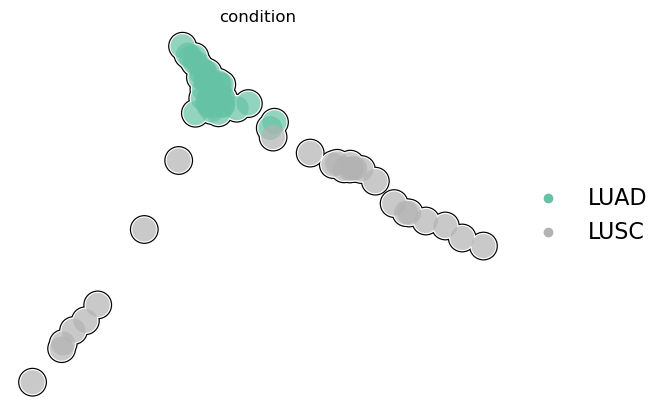

In [140]:
sc.pl.umap(test_adata,color='condition',size=1200,legend_fontsize=16,palette="Set2",
    frameon=False,add_outline=True,outline_width=(0.05,0.05))

/sibcb1/chenluonanlab8/miaoyuanxiang/miniforge3/envs/GAE/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:343: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/sibcb1/chenluonanlab8/miaoyuanxiang/miniforge3/envs/GAE/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:352: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(


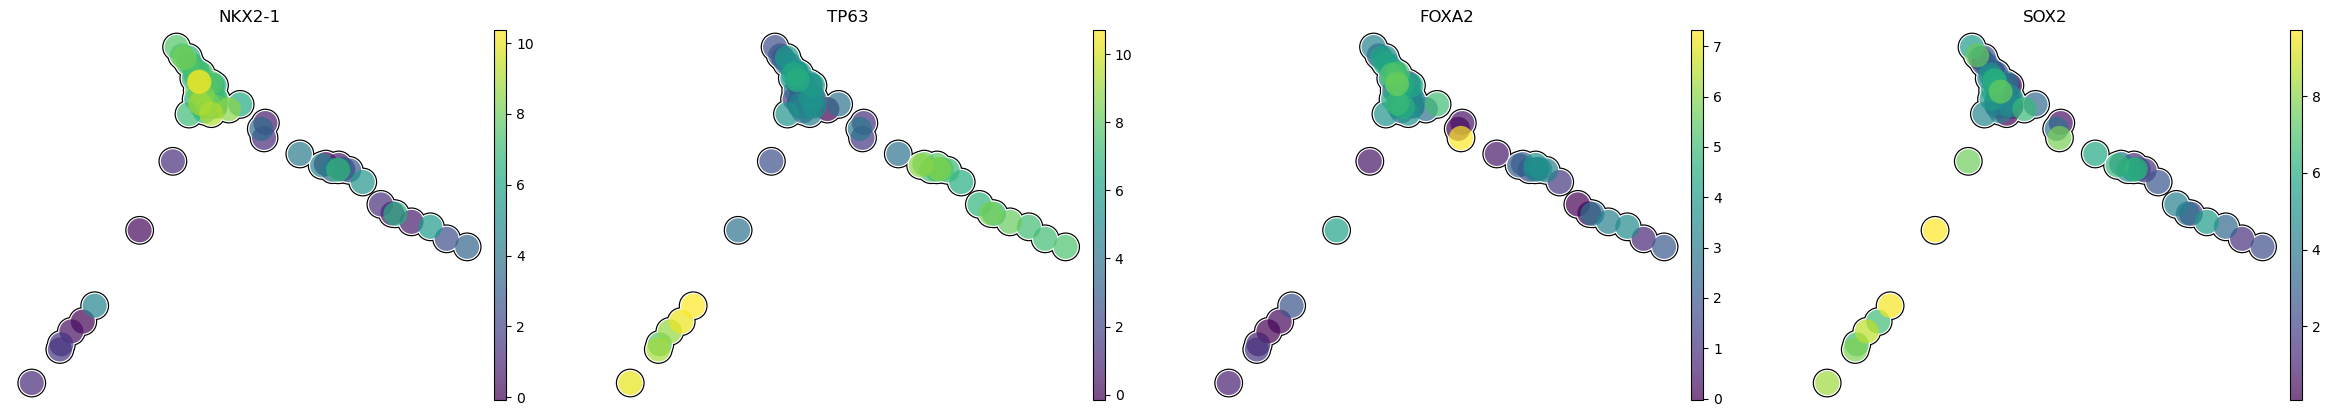

In [143]:
sc.pl.umap(test_adata,color=['NKX2-1','TP63','FOXA2','SOX2'],size=1200,legend_fontsize=16,palette="Set2",
    frameon=False,add_outline=True,outline_width=(0.05,0.05))

/sibcb1/chenluonanlab8/miaoyuanxiang/miniforge3/envs/GAE/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:343: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/sibcb1/chenluonanlab8/miaoyuanxiang/miniforge3/envs/GAE/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:352: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/sibcb1/chenluonanlab8/miaoyuanxiang/miniforge3/envs/GAE/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:364: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


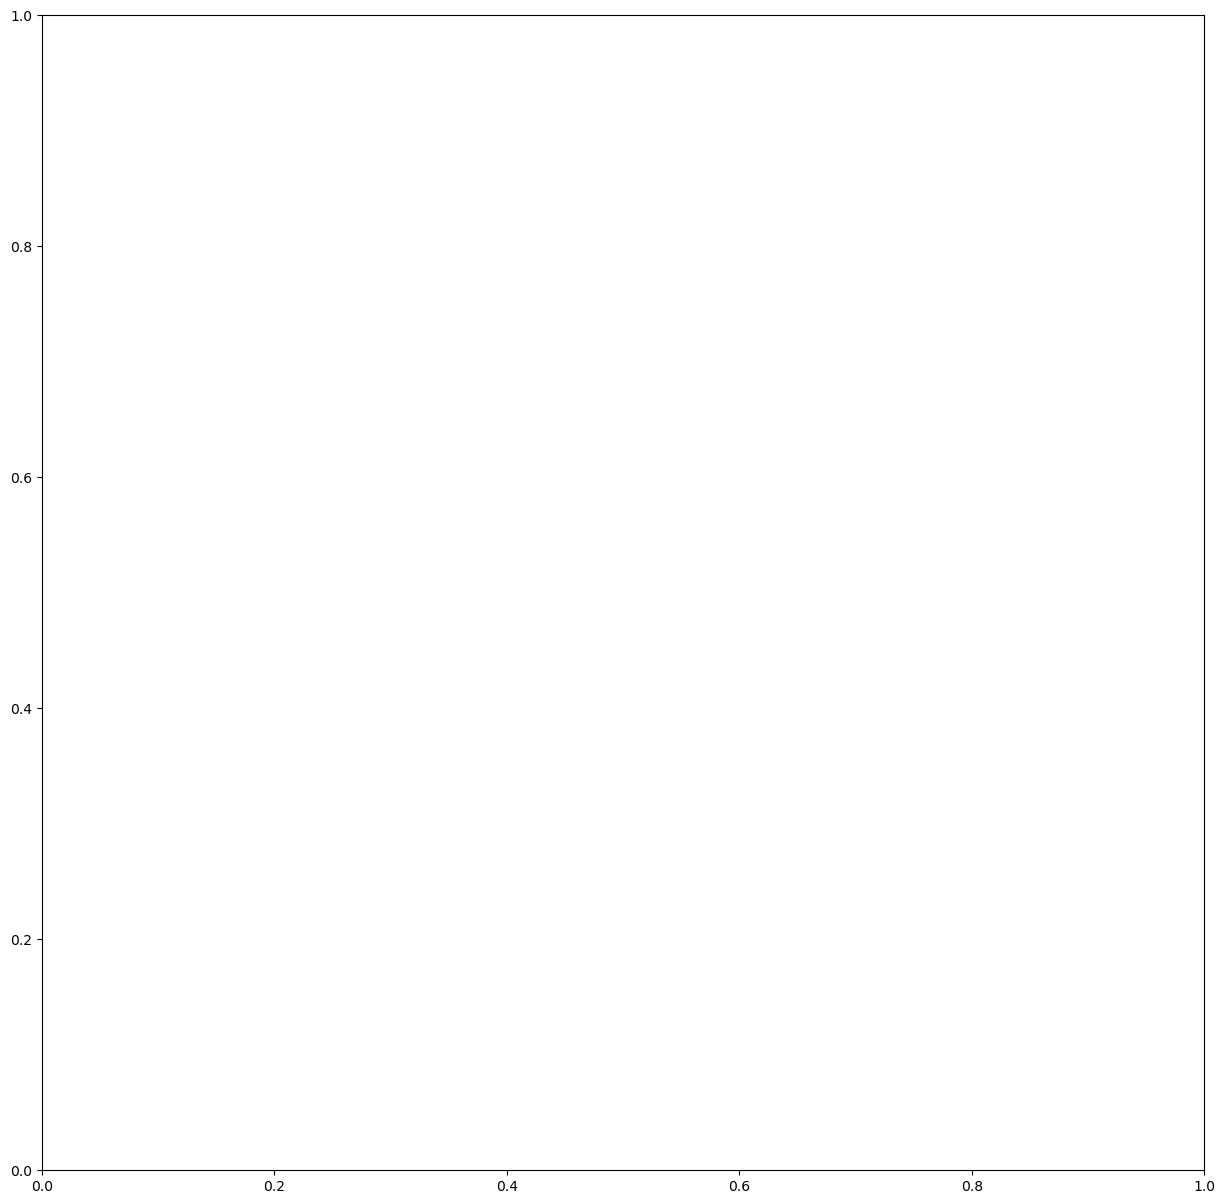

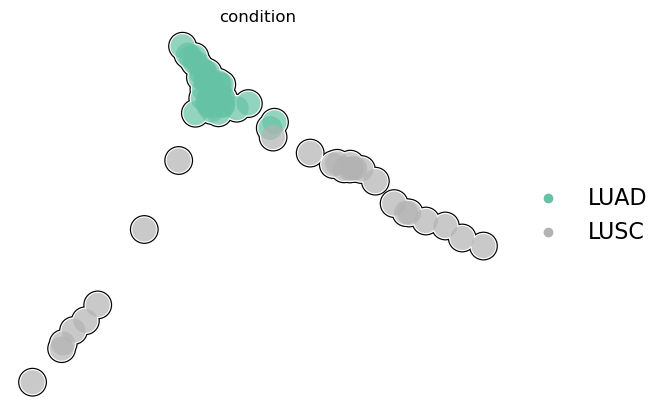

<Figure size 640x480 with 0 Axes>

In [144]:
fig,ax=plt.subplots(figsize=(15,15))
sc.pl.umap(test_adata,color='condition',size=1200,legend_fontsize=16,palette="Set2",
    frameon=False,add_outline=True,outline_width=(0.05,0.05))
#plt.savefig("/sibcb1/chenluonanlab8/miaoyuanxiang/CauFinder-master/cycleCancer_net/t0_t7_orgin_pumap_time.png",dpi=300,bbox_inches='tight')
plt.savefig("/sibcb1/chenluonanlab8/miaoyuanxiang/CauFinder-master/LUAS/human/human_pca_condition.pdf")

/sibcb1/chenluonanlab8/miaoyuanxiang/miniforge3/envs/GAE/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:343: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/sibcb1/chenluonanlab8/miaoyuanxiang/miniforge3/envs/GAE/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:352: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/sibcb1/chenluonanlab8/miaoyuanxiang/miniforge3/envs/GAE/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:364: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


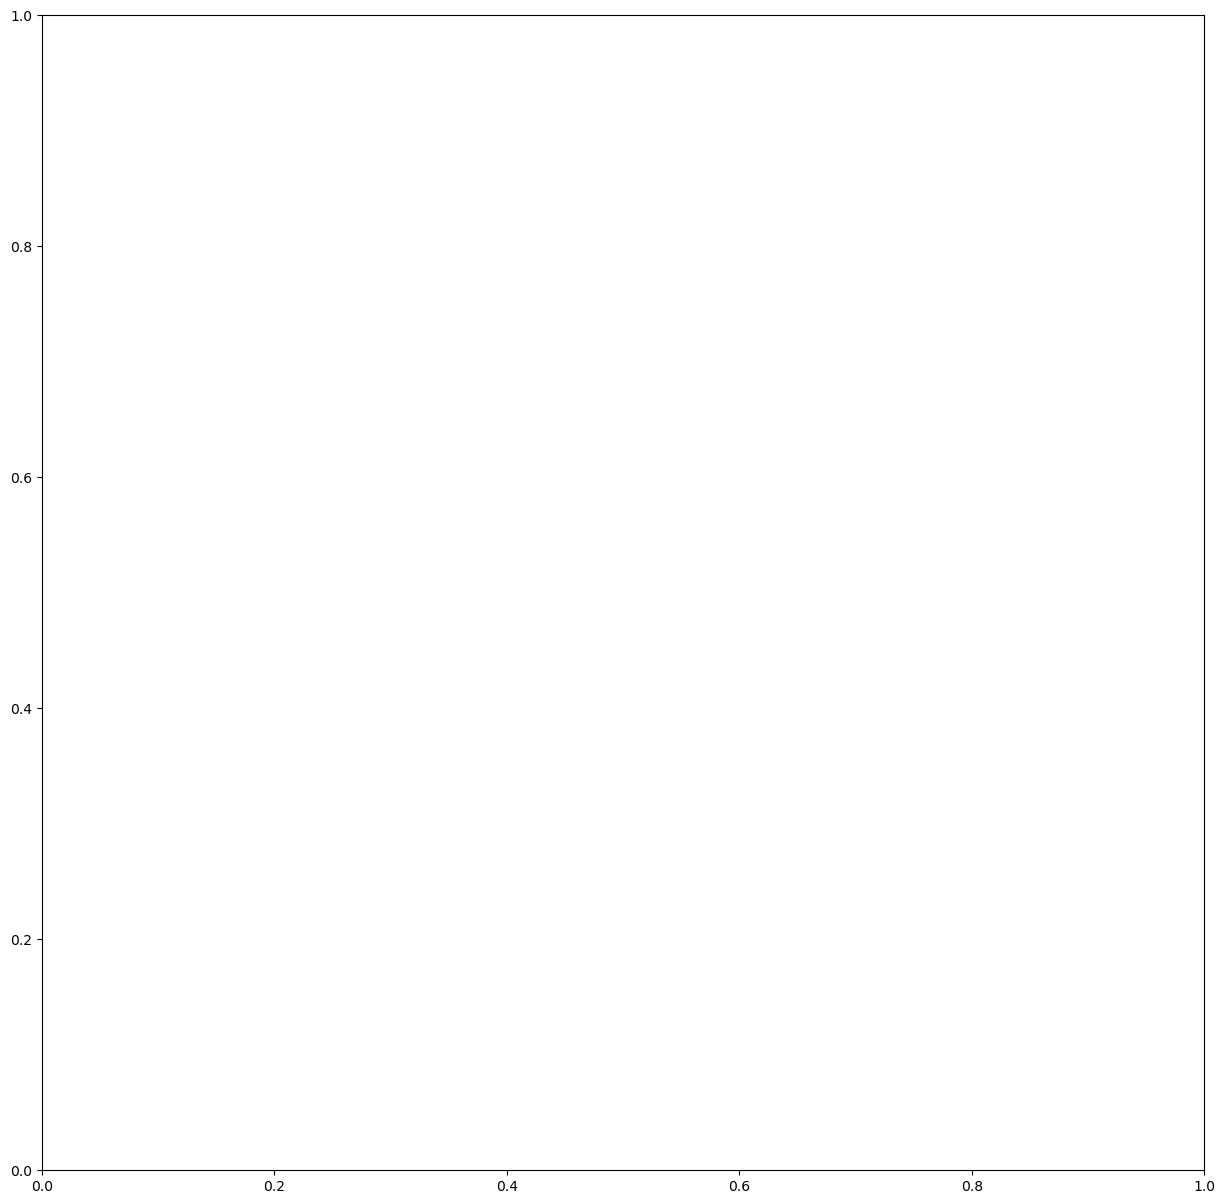

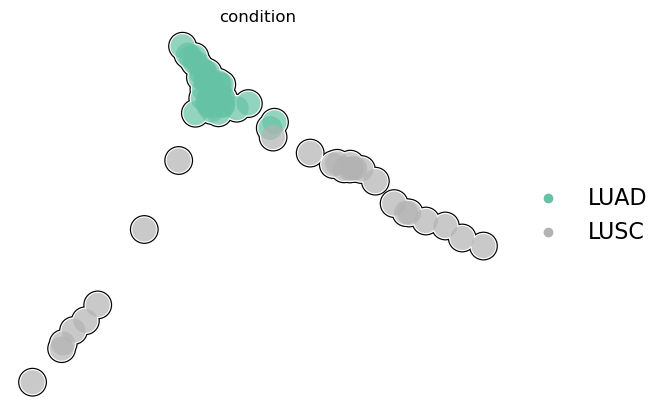

In [149]:
fig,ax=plt.subplots(figsize=(15,15))
sc.pl.umap(test_adata,color='condition',size=1200,legend_fontsize=16,palette="Set2",
    frameon=False,add_outline=True,outline_width=(0.05,0.05),return_fig=True)
#plt.savefig("/sibcb1/chenluonanlab8/miaoyuanxiang/CauFinder-master/cycleCancer_net/t0_t7_orgin_pumap_time.png",dpi=300,bbox_inches='tight')
plt.savefig("/sibcb1/chenluonanlab8/miaoyuanxiang/CauFinder-master/LUAS/human/human_umap_condition.pdf", bbox_inches='tight')

/sibcb1/chenluonanlab8/miaoyuanxiang/miniforge3/envs/GAE/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:343: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/sibcb1/chenluonanlab8/miaoyuanxiang/miniforge3/envs/GAE/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:352: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(


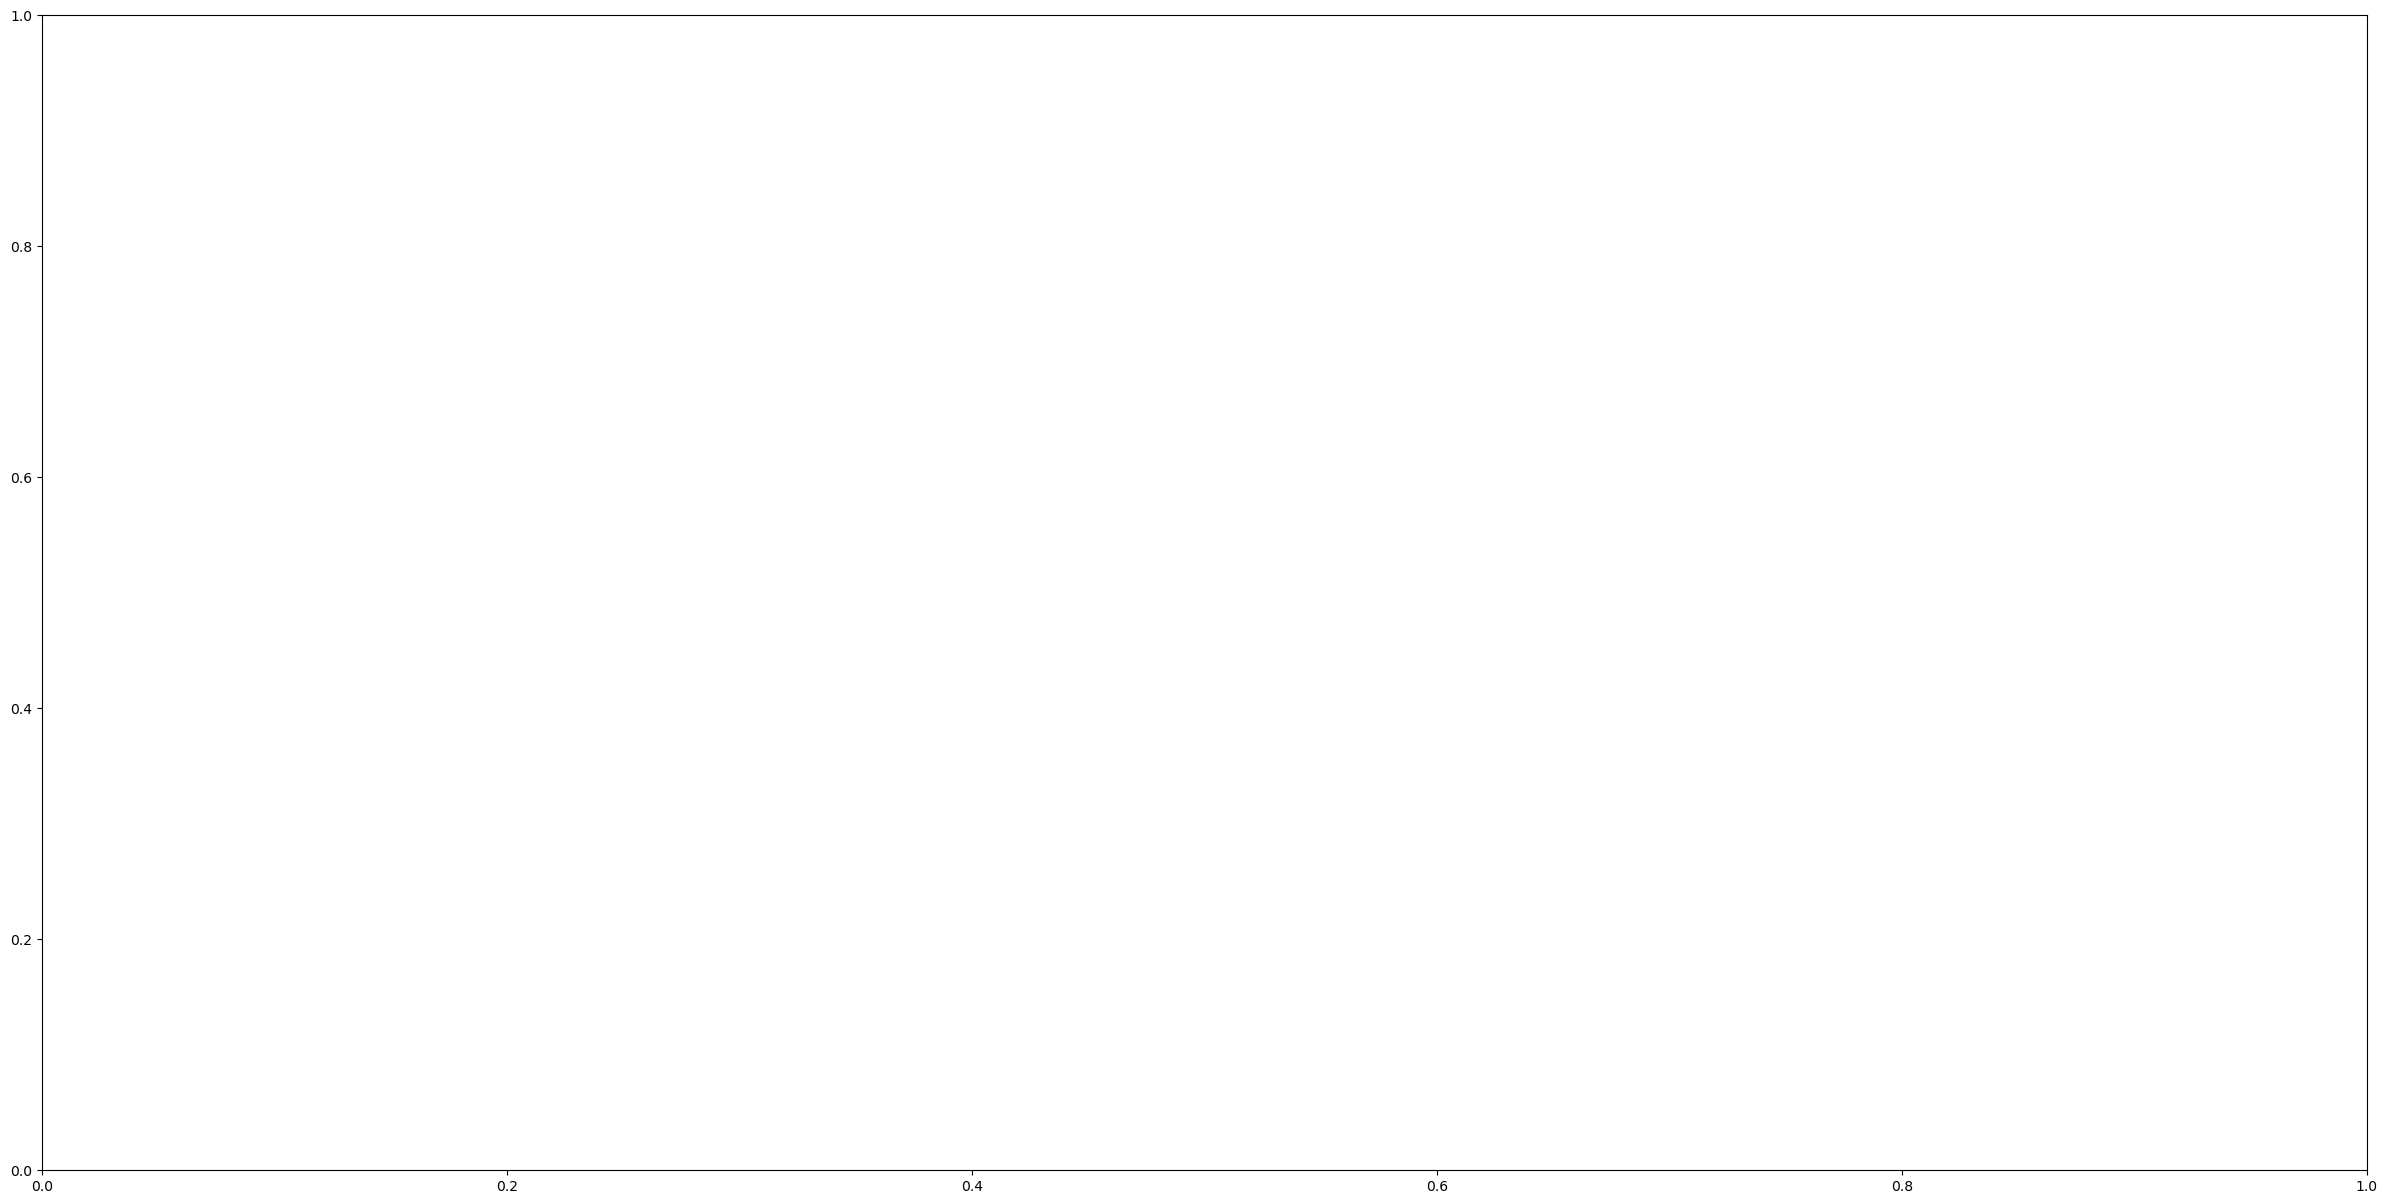

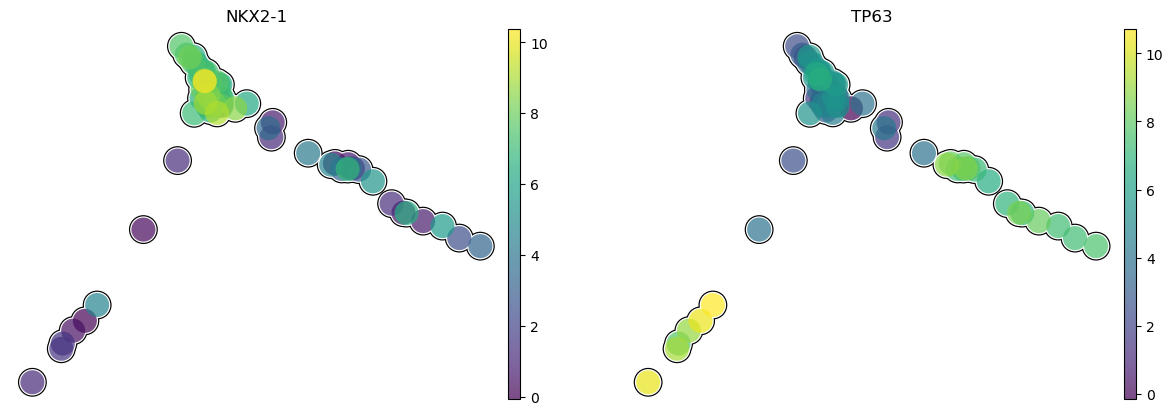

In [154]:
fig,ax=plt.subplots(figsize=(30,15))
sc.pl.umap(test_adata,color=['NKX2-1','TP63'],size=1200,legend_fontsize=16,palette="Set2",
    frameon=False,add_outline=True,outline_width=(0.05,0.05),return_fig=True)
#plt.savefig("/sibcb1/chenluonanlab8/miaoyuanxiang/CauFinder-master/cycleCancer_net/t0_t7_orgin_pumap_time.png",dpi=300,bbox_inches='tight')
plt.savefig("/sibcb1/chenluonanlab8/miaoyuanxiang/CauFinder-master/LUAS/human/human_umap_NKX21_TP63.pdf", bbox_inches='tight')

/sibcb1/chenluonanlab8/miaoyuanxiang/miniforge3/envs/GAE/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:343: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/sibcb1/chenluonanlab8/miaoyuanxiang/miniforge3/envs/GAE/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:352: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(


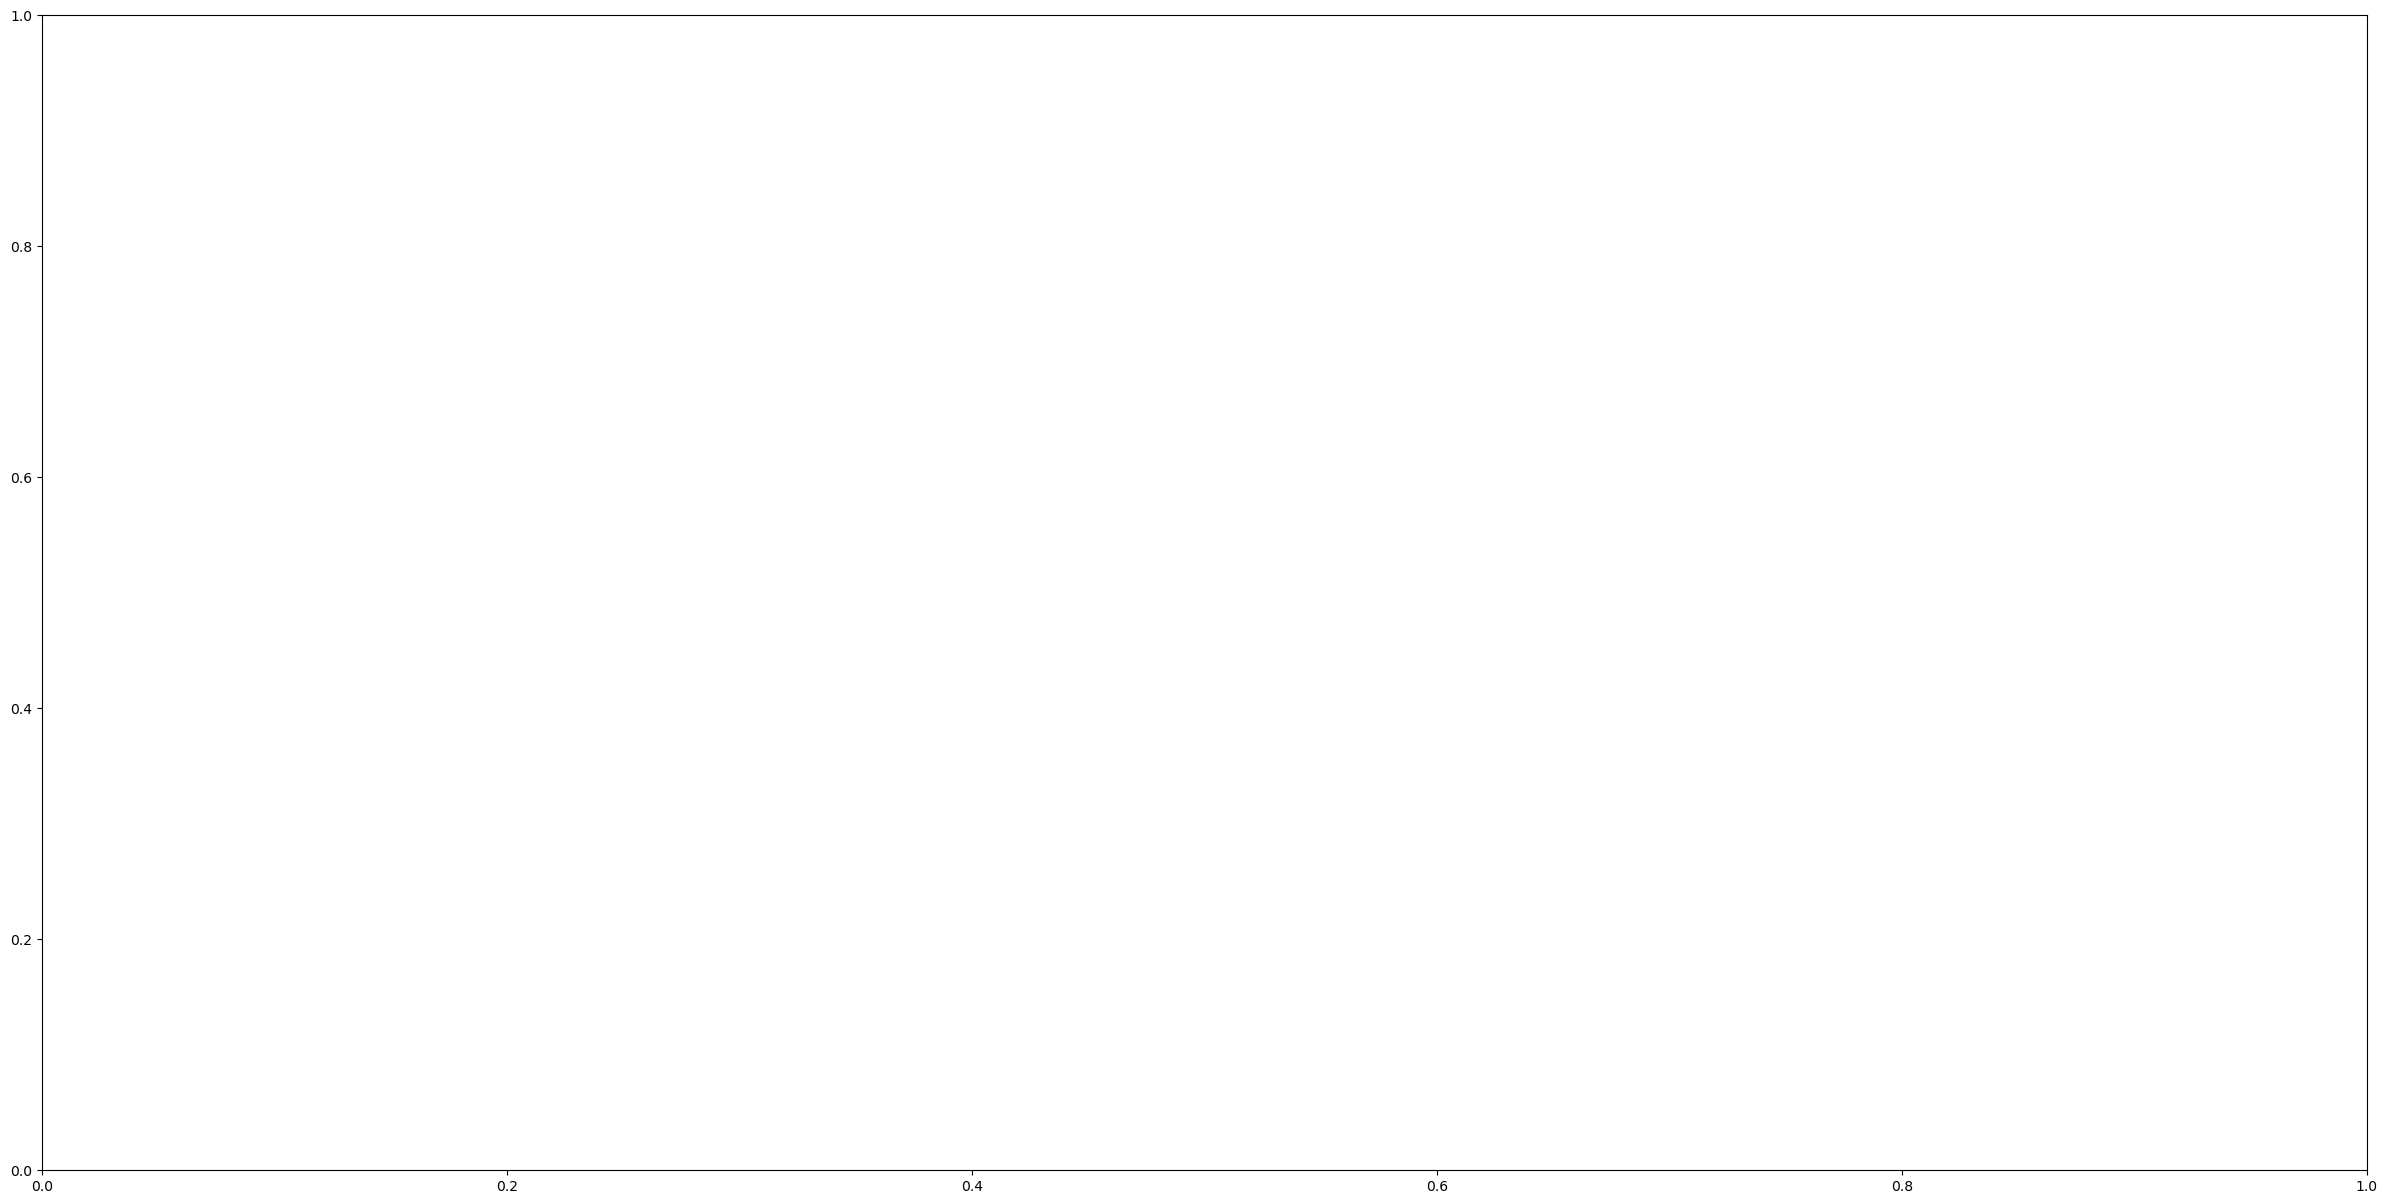

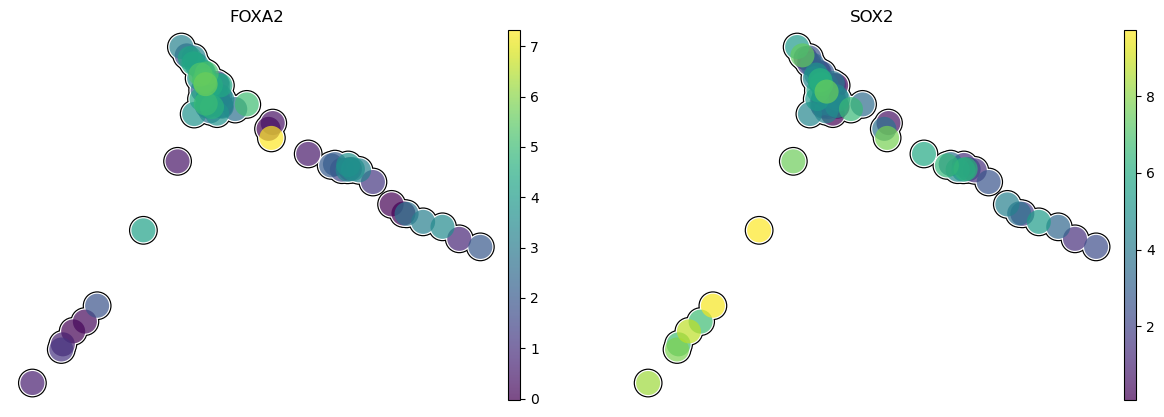

In [152]:
fig,ax=plt.subplots(figsize=(30,15))
sc.pl.umap(test_adata,color=['FOXA2','SOX2'],size=1200,legend_fontsize=16,palette="Set2",
    frameon=False,add_outline=True,outline_width=(0.05,0.05),return_fig=True)
#plt.savefig("/sibcb1/chenluonanlab8/miaoyuanxiang/CauFinder-master/cycleCancer_net/t0_t7_orgin_pumap_time.png",dpi=300,bbox_inches='tight')
plt.savefig("/sibcb1/chenluonanlab8/miaoyuanxiang/CauFinder-master/LUAS/human/human_umap_FOXA2_SOX2.pdf", bbox_inches='tight')

/sibcb1/chenluonanlab8/miaoyuanxiang/miniforge3/envs/GAE/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:343: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/sibcb1/chenluonanlab8/miaoyuanxiang/miniforge3/envs/GAE/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:352: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(


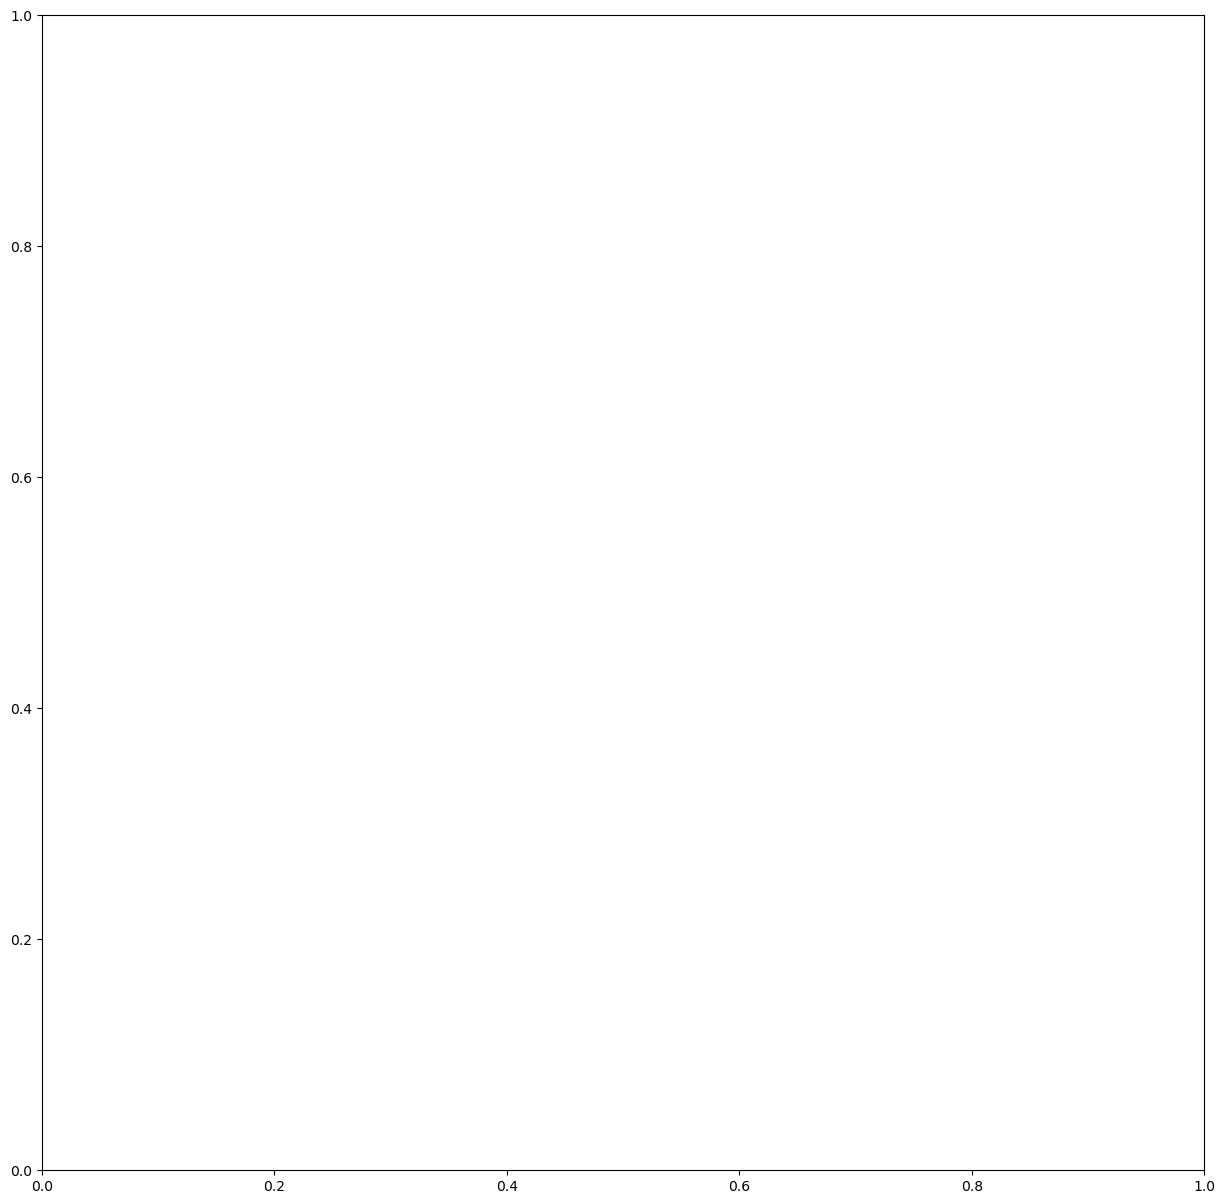

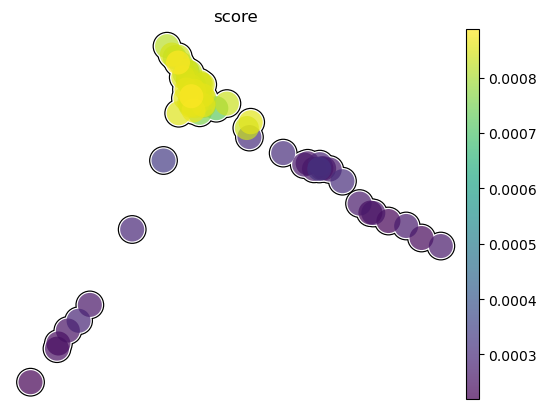

In [155]:
fig,ax=plt.subplots(figsize=(15,15))
sc.pl.umap(test_adata,color='score',size=1200,legend_fontsize=16,palette="Set2",
    frameon=False,add_outline=True,outline_width=(0.05,0.05),return_fig=True)
#plt.savefig("/sibcb1/chenluonanlab8/miaoyuanxiang/CauFinder-master/cycleCancer_net/t0_t7_orgin_pumap_time.png",dpi=300,bbox_inches='tight')
plt.savefig("/sibcb1/chenluonanlab8/miaoyuanxiang/CauFinder-master/LUAS/human/human_umap_score.pdf", bbox_inches='tight')

### color with decrease score

In [162]:
test_adata.obs['decreasing score'] = adata_decrease.uns['control_details']['score'].to_list()

/sibcb1/chenluonanlab8/miaoyuanxiang/miniforge3/envs/GAE/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:343: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/sibcb1/chenluonanlab8/miaoyuanxiang/miniforge3/envs/GAE/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:352: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(


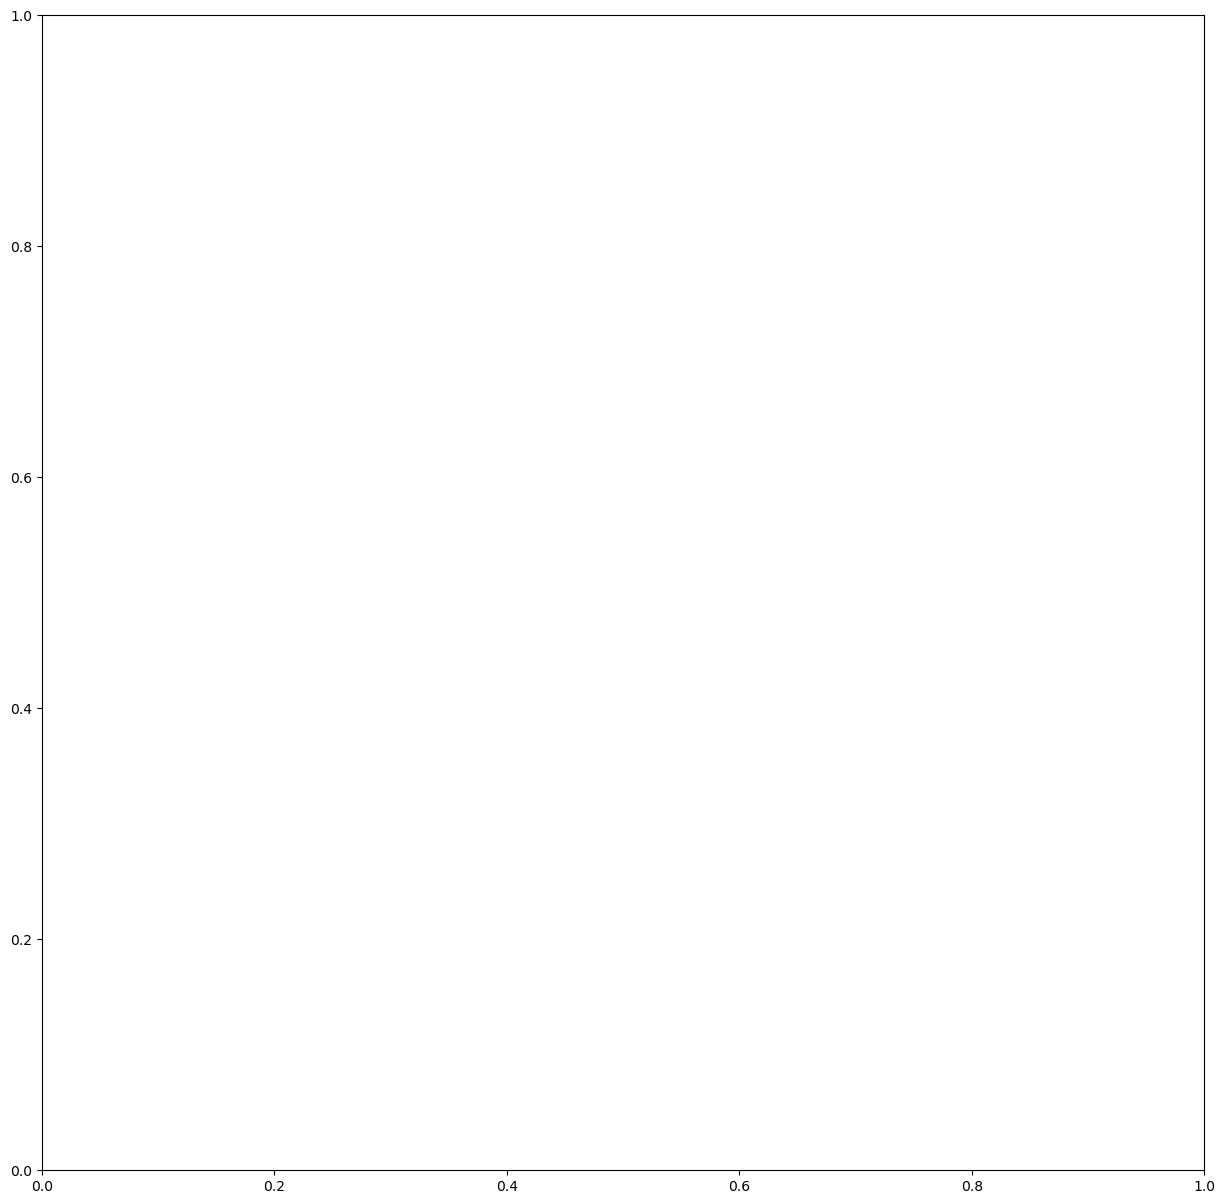

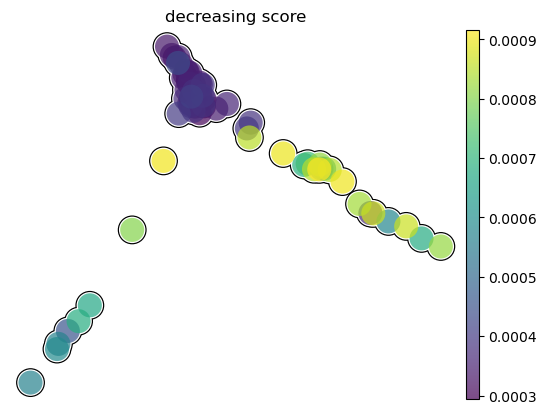

In [164]:
fig,ax=plt.subplots(figsize=(15,15))
sc.pl.umap(test_adata,color='decreasing score',size=1200,legend_fontsize=16,palette="Set2",
    frameon=False,add_outline=True,outline_width=(0.05,0.05),return_fig=True)
#plt.savefig("/sibcb1/chenluonanlab8/miaoyuanxiang/CauFinder-master/cycleCancer_net/t0_t7_orgin_pumap_time.png",dpi=300,bbox_inches='tight')
plt.savefig("/sibcb1/chenluonanlab8/miaoyuanxiang/CauFinder-master/LUAS/human/human_umap_DEscore.pdf", bbox_inches='tight')

In [198]:
sc.tl.leiden(
    test_adata,
    resolution=0.25,
    random_state=0,
    directed=False,
)

/sibcb1/chenluonanlab8/miaoyuanxiang/miniforge3/envs/GAE/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:364: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/sibcb1/chenluonanlab8/miaoyuanxiang/miniforge3/envs/GAE/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:364: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


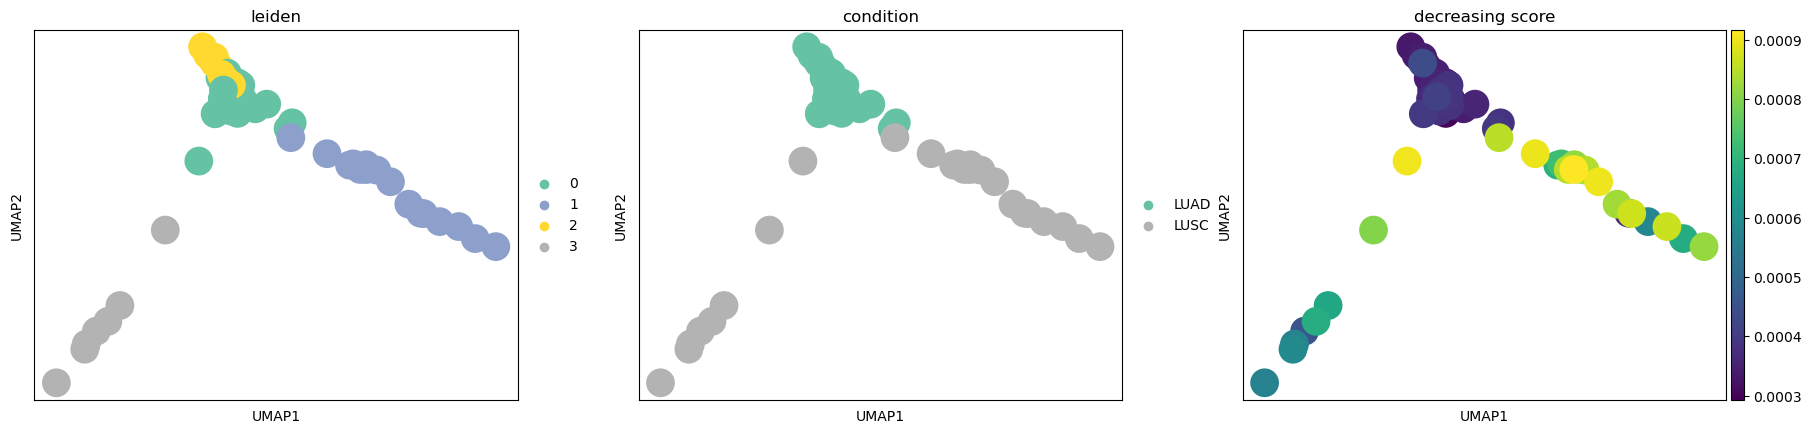

In [208]:
sc.pl.umap(test_adata, color=["leiden", "condition", "decreasing score"],palette="Set2",)

/sibcb1/chenluonanlab8/miaoyuanxiang/miniforge3/envs/GAE/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:343: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/sibcb1/chenluonanlab8/miaoyuanxiang/miniforge3/envs/GAE/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:352: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/sibcb1/chenluonanlab8/miaoyuanxiang/miniforge3/envs/GAE/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:364: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


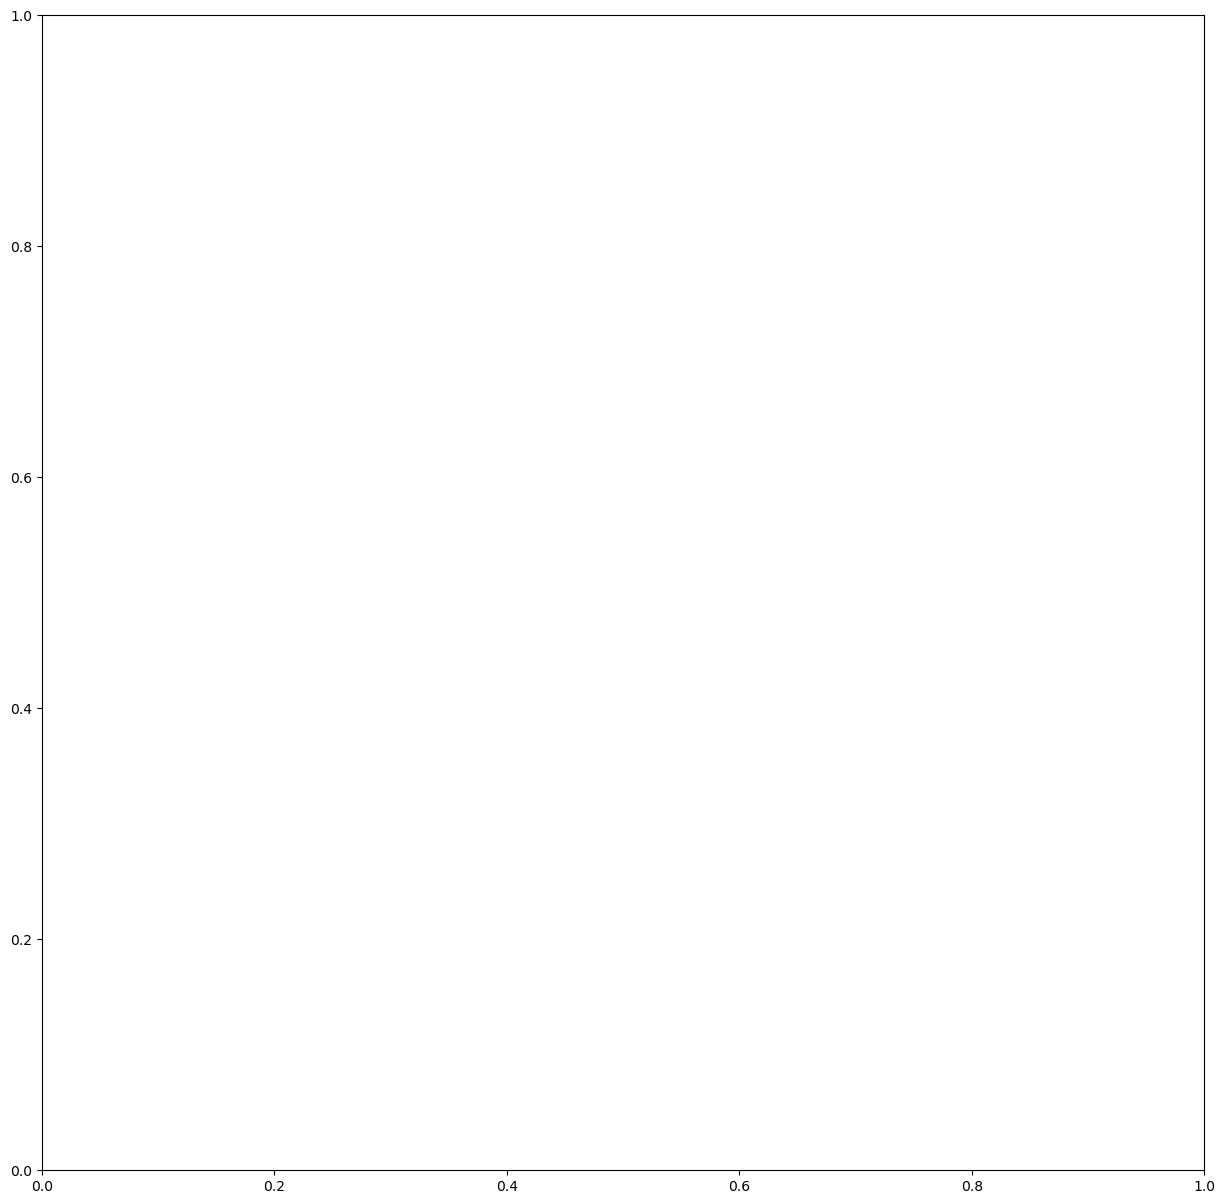

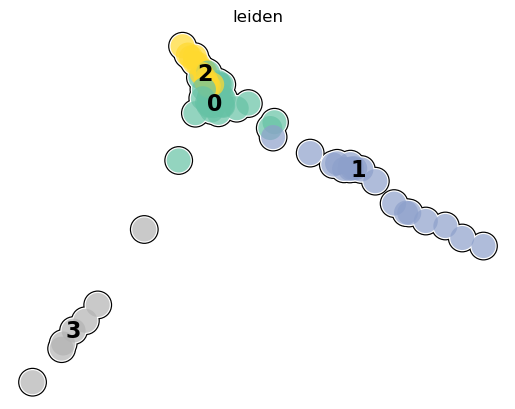

In [210]:
fig,ax=plt.subplots(figsize=(15,15))
sc.pl.umap(test_adata,color='leiden',size=1200,legend_loc="on data",legend_fontsize=16,palette="Set2",
    frameon=False,add_outline=True,outline_width=(0.05,0.05),return_fig=True)
#plt.savefig("/sibcb1/chenluonanlab8/miaoyuanxiang/CauFinder-master/cycleCancer_net/t0_t7_orgin_pumap_time.png",dpi=300,bbox_inches='tight')
plt.savefig("/sibcb1/chenluonanlab8/miaoyuanxiang/CauFinder-master/LUAS/human/human_umap_leiden.pdf", bbox_inches='tight')

In [213]:
change_id = { '2':'Cluster 1','0':'Cluster 2','1':'Cluster 3','3':'Cluster 4'}
test_adata.obs['draw_cls'] = [change_id[i] for i in test_adata.obs['leiden']]

In [216]:
test_adata.obs.to_csv('/sibcb1/chenluonanlab8/miaoyuanxiang/CauFinder-master/LUAS/human/LUAS_human_adata_info.csv')

/sibcb1/chenluonanlab8/miaoyuanxiang/miniforge3/envs/GAE/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:343: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/sibcb1/chenluonanlab8/miaoyuanxiang/miniforge3/envs/GAE/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:352: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/sibcb1/chenluonanlab8/miaoyuanxiang/miniforge3/envs/GAE/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:364: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


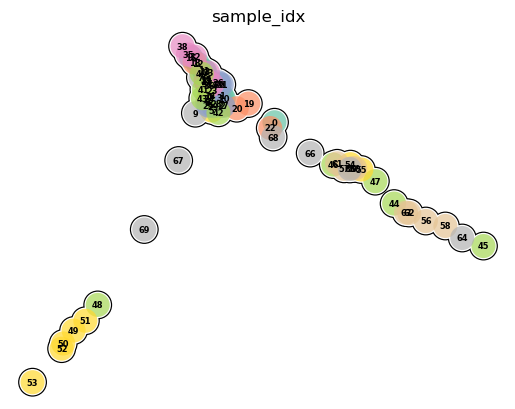

In [218]:
sc.pl.umap(test_adata,color='sample_idx',legend_loc="on data",size=1200,legend_fontsize=6,palette="Set2",
    frameon=False,add_outline=True,outline_width=(0.05,0.05))

### state trans for sample

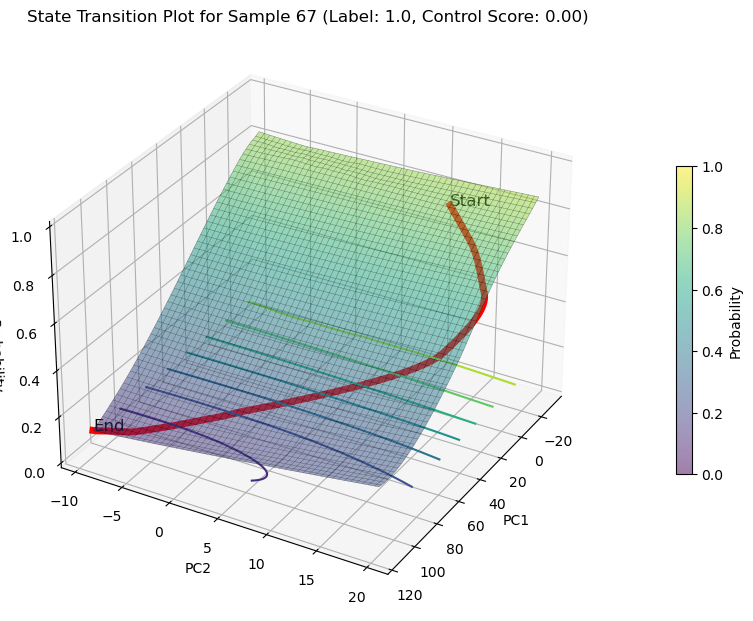

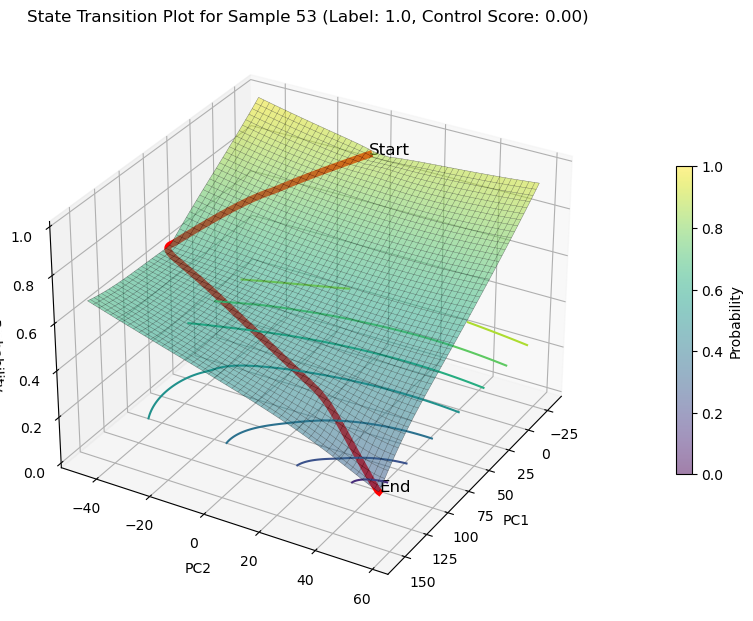

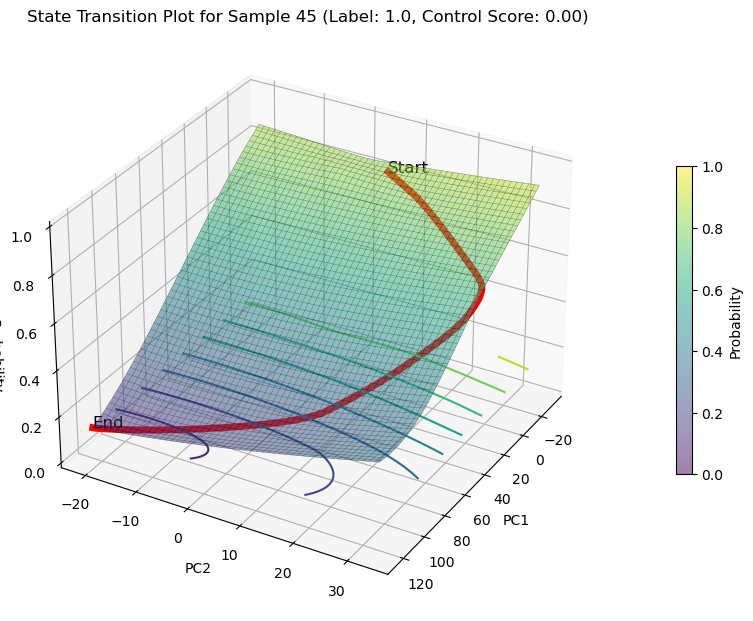

In [220]:
plot_3d_state_transition(adata_decrease, sample_indices=[67,53,45], use_pca=True)

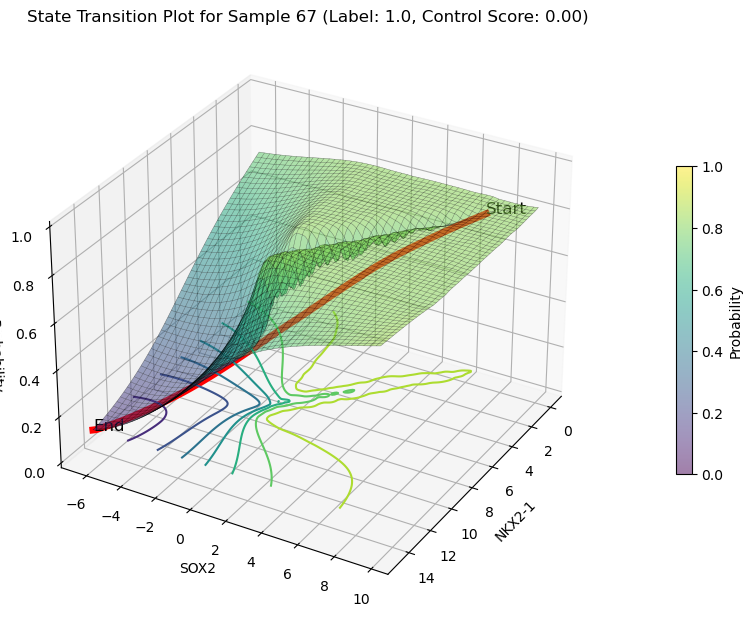

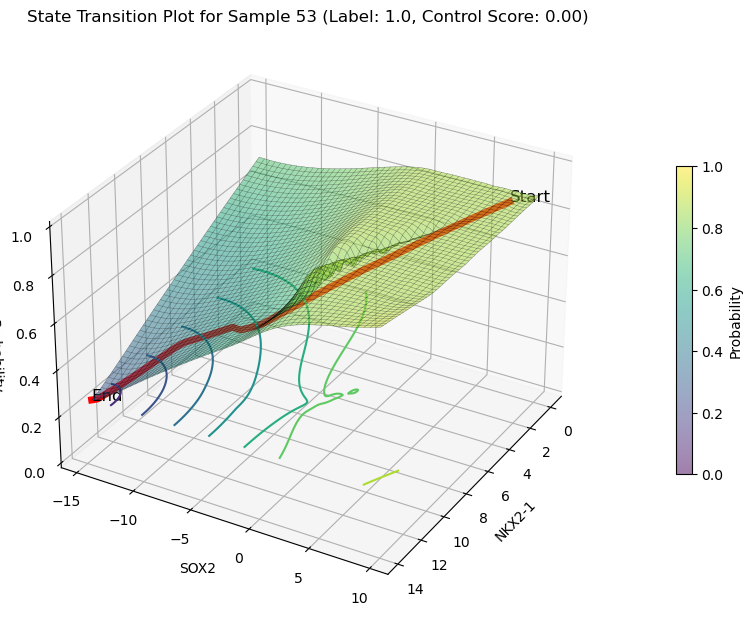

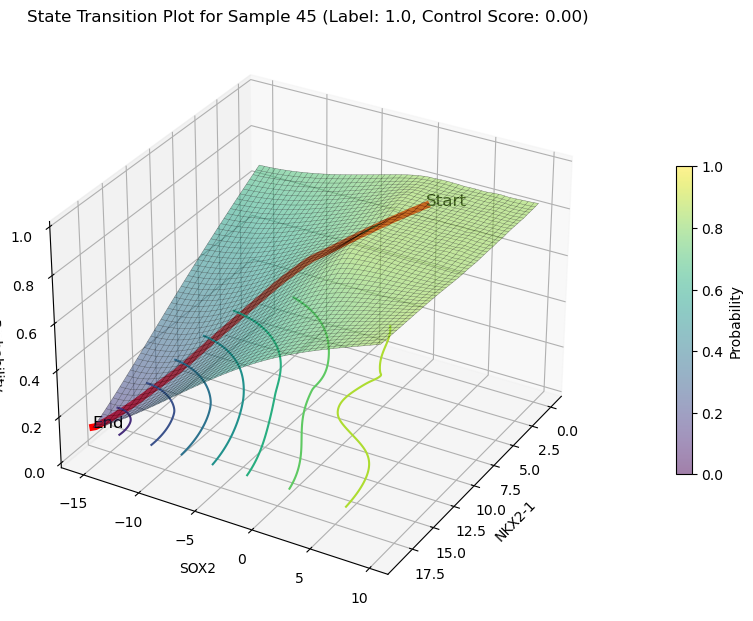

In [227]:
plot_3d_state_transition(adata_decrease, sample_indices=[67,53,45], use_pca=False, feature1='NKX2-1',feature2='SOX2',save_path='/sibcb1/chenluonanlab8/miaoyuanxiang/CauFinder-master/LUAS/human/decrease/')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


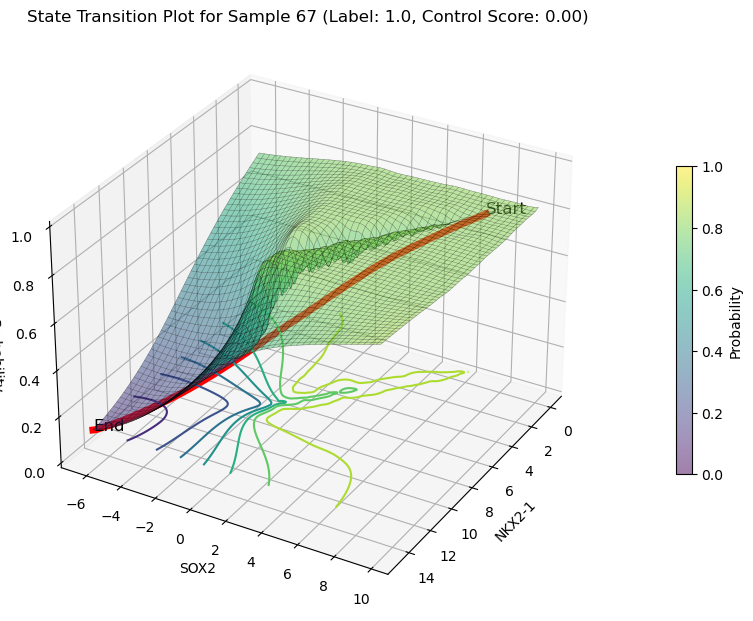

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

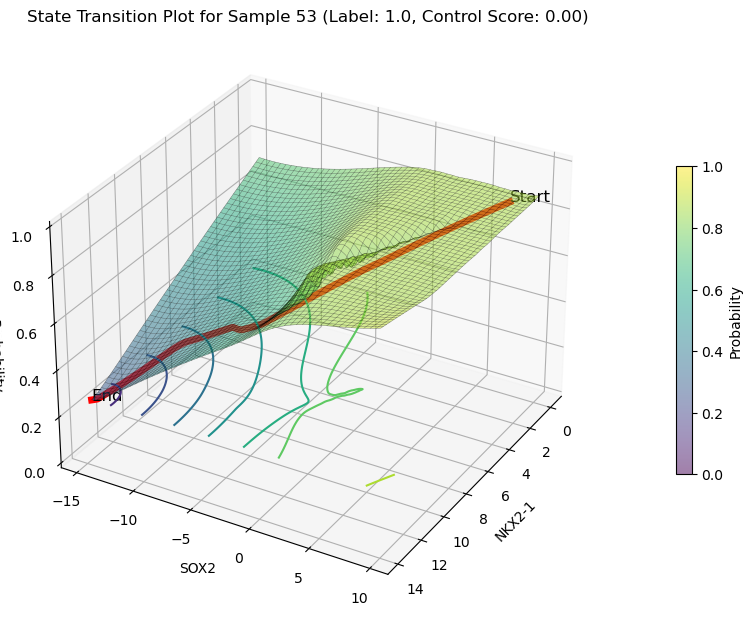

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

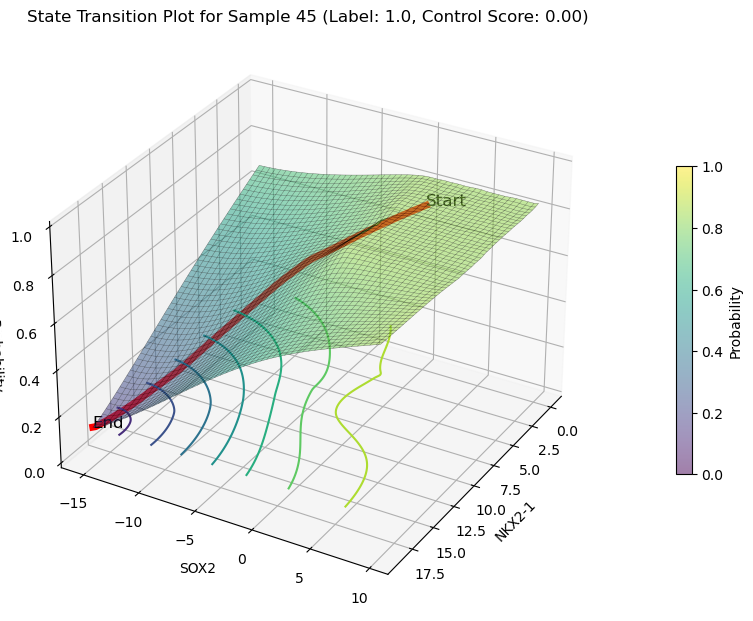

In [12]:
plot_3d_state_transition(adata_decrease, sample_indices=[67,53,45], use_pca=False, feature1='NKX2-1',feature2='SOX2',save_path='/sibcb1/chenluonanlab8/miaoyuanxiang/CauFinder-master/LUAS/human/decrease/')